<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1a5ab;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
    
<p style="padding: 10px;
              color:white;">
    
# **Wine quality 🍷** 

The aim is to predict the quality of wine based on parameters such as pH, citric acid content etc.
 
* <a href="#section-one" style="color: #2F4F4F;">Introduction</a> 
* <a href="#section-two" style="color: #2F4F4F;">EDA</a>
* <a href="#section-three" style="color: #2F4F4F;">Prediction using lda, svm and random forest</a>

</p>
</div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1a5ab;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
<a id="section-one"></a>
    
## **Loading data** 

- combining the quality classes:
    * quality 3 and 4 became *1*
    * quality 5 and 6 became *2*
    * quality 7 and 8 became *3*

In [1]:
# load libraries
# =============================================================================================
options(warn = -1) 
library(tidyverse) 
library(tidymodels)  
library(future) 
library(caret)
library(ggfortify)
library(ggcorrplot)
library(doParallel)
library(MASS)
library(mda)
library(e1071)
#Parallelisation
cores <- parallel::detectCores(logical = FALSE)
registerDoParallel(cores = cores)
# import data
# =============================================================================================
df <- read_delim('../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv', show_col_types = FALSE)
# combine class 3 & 4 to 1, 5 & 6 to 2 and 7 & 8 to 3
for(i in 1:length(df$quality)) {
  q <- df[i, "quality"]
  if(q <= 4) {
    df[i, "quality"] <- 1L
  } else if( (q > 4) & (q < 7)) {
    df[i, "quality"] <- 2L
  } else {
    df[i, "quality"] <- 3L
  }
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1a5ab;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
  
<a id="section-two"></a>
    
## **Explore the data**
    
1. Boxplots of predictors against the three quality classes
2. Detect correlations within the dataset
3. Create PCA 
    - **one clearly sees that the quality classes are not well seperated!!!**

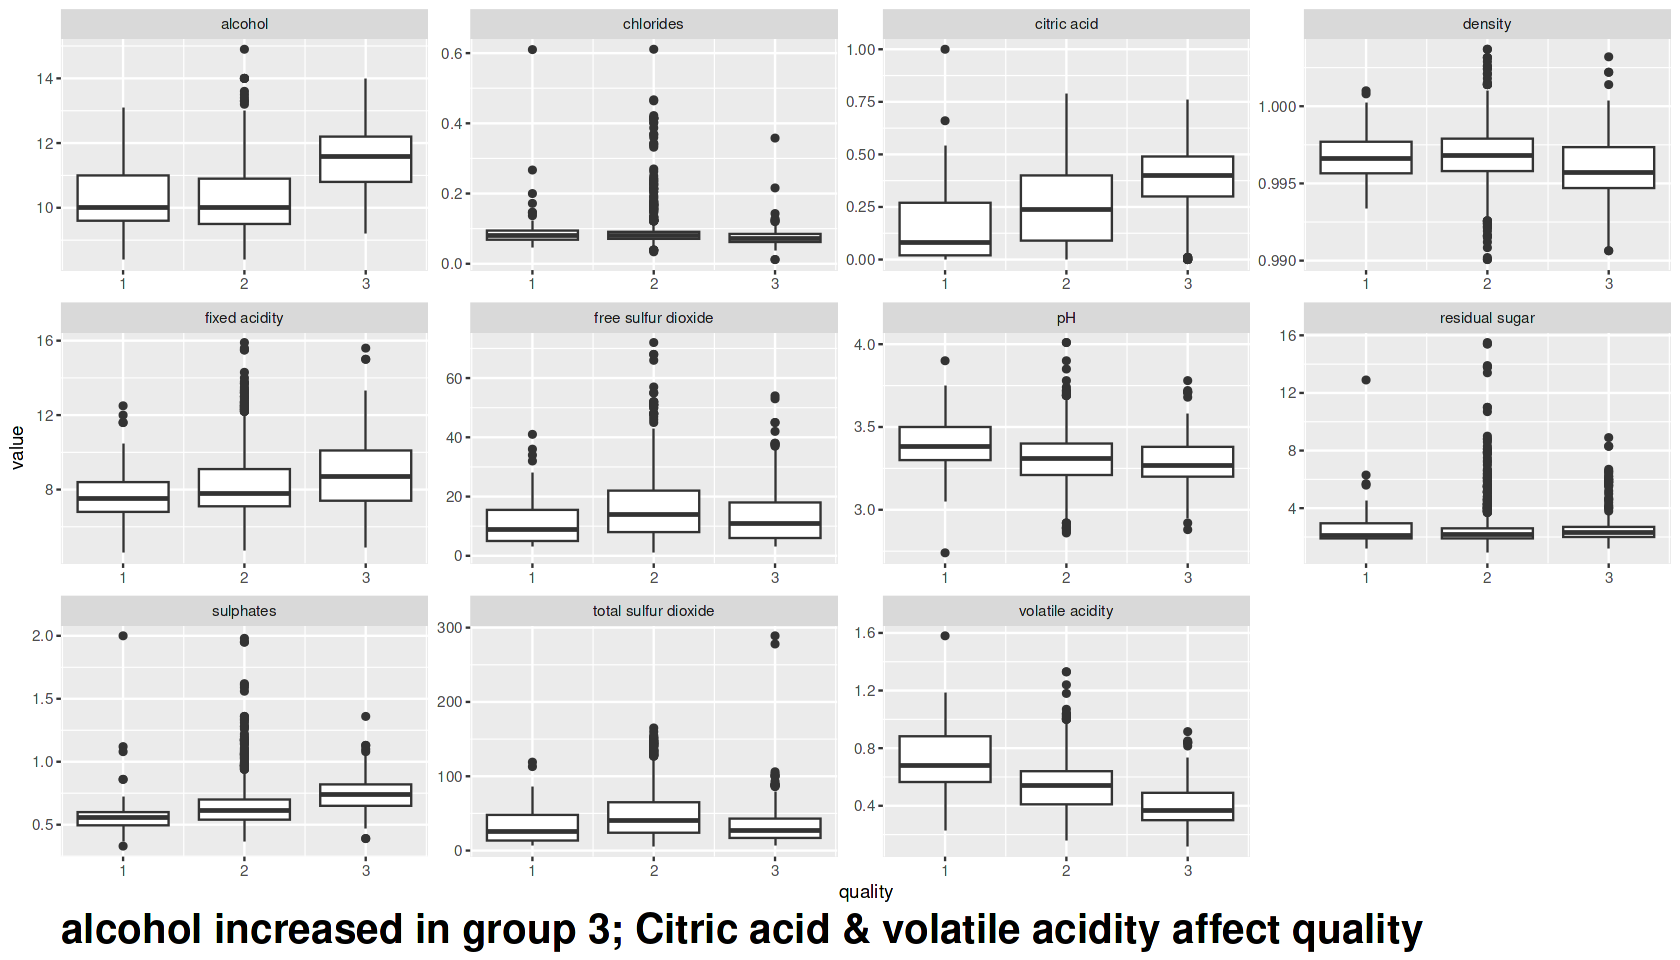

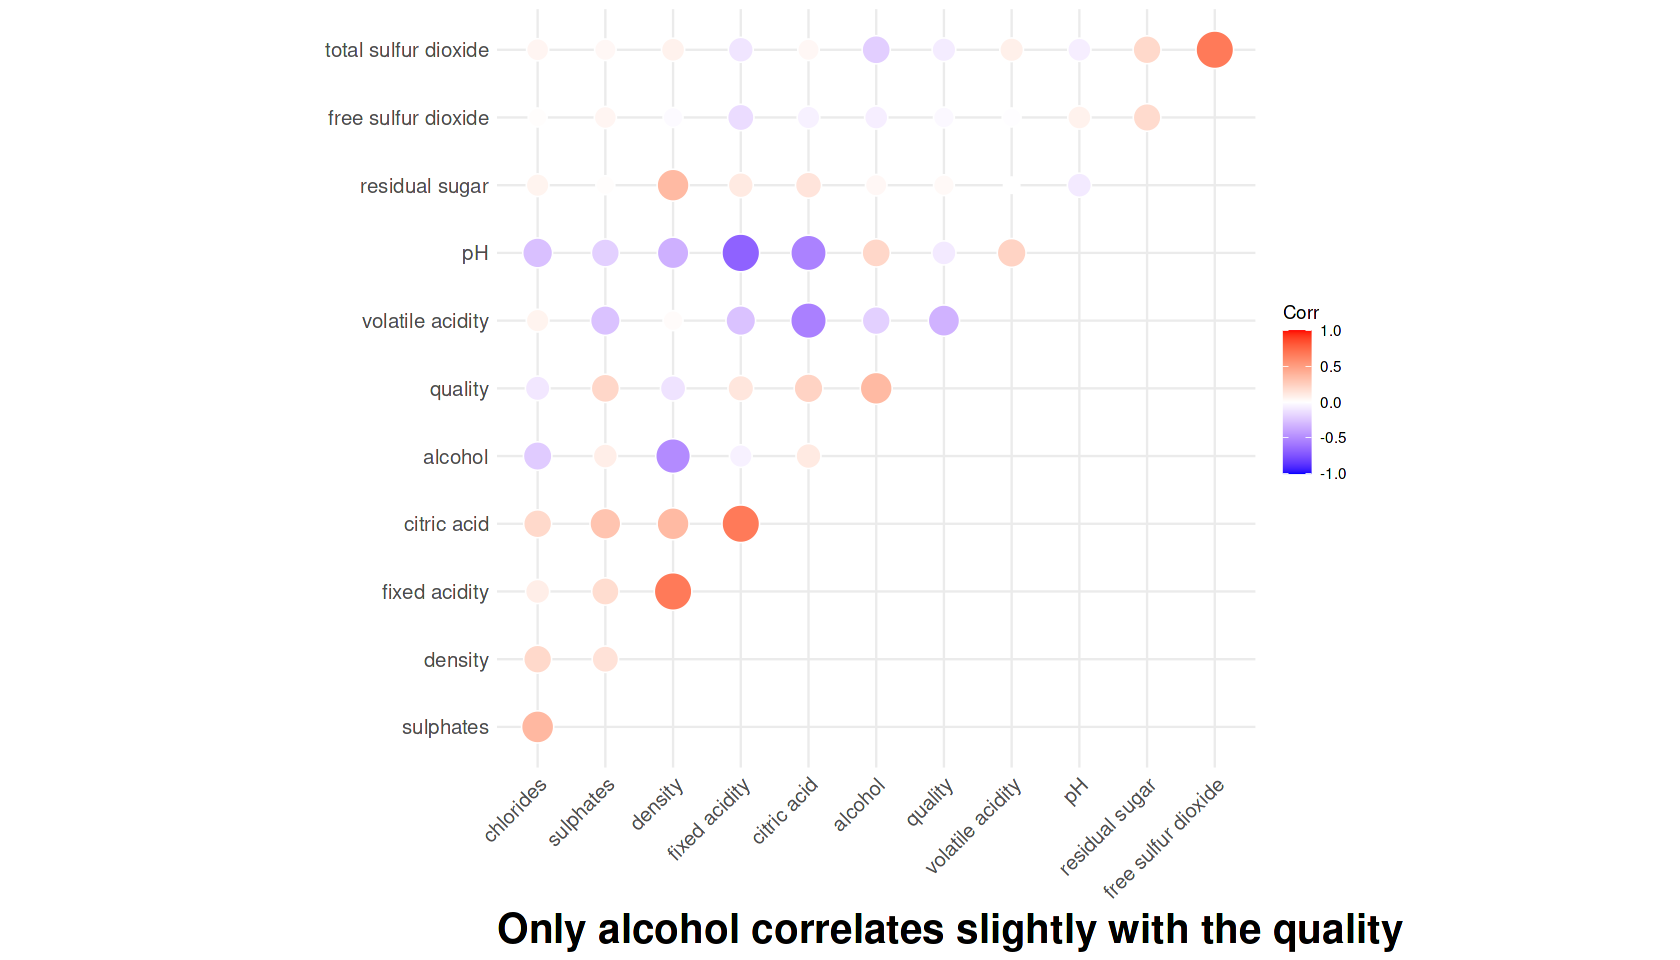

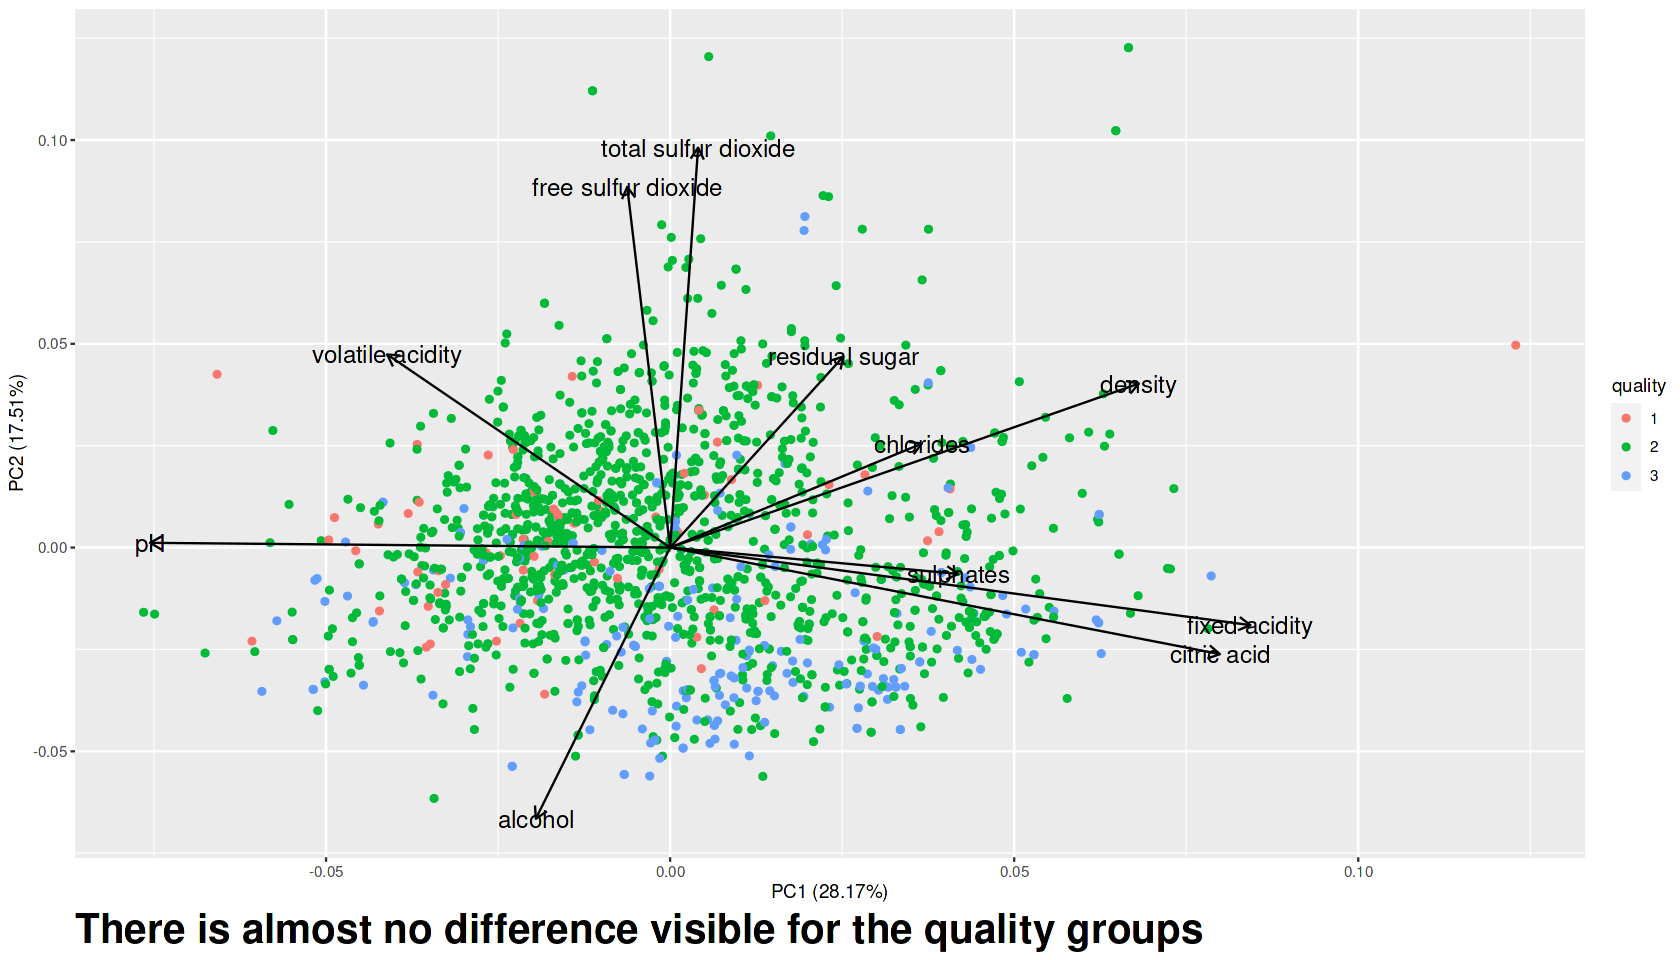

In [2]:
# Visualisation
# =============================================================================================
options(repr.plot.width = 14, repr.plot.height = 8)
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
# detect noisy predictors
bp <- function(df) {
  df <- pivot_longer(df, cols = -quality)
  ggplot(data = df, aes(x = quality, y = value, group = quality), fig(10,4)) +
    geom_boxplot() +
    facet_wrap(name ~., scales = "free") +
    labs(caption = bquote("alcohol increased in group 3; Citric acid & volatile acidity affect quality")) +
    theme(plot.caption = element_text(hjust = 0, size = 24, face = "bold"))
}

# needed for normalising
means <- apply(df[, 1:dim(df)[2]], 2, mean)
sds <- apply(df[, 1:dim(df)[2]], 2, sd)

# corplot
cp <- function(df) {
  for(i in 1:dim(df)[2]) {
    df[, i] <- (df[, i] - means[i]) / sds[i]
  }
  m <- cor(df)
  ggcorrplot(m, hc.order = TRUE, type = "upper", 
             insig = "blank",
             outline.col = "white", method = "circle") +
    labs(caption = bquote("Only alcohol correlates slightly with the quality")) +
    theme(plot.caption = element_text(hjust = 0, size = 24, face = "bold"))
}

# PCA
pca_plot <- function(df) {
  df$quality <- as.factor(df$quality)
  pca_fit <- prcomp(df[, 1:dim(df)[2]-1], scale = TRUE, center = TRUE)
  autoplot(pca_fit, data = df, 
           loadings.colour = "black",
           loadings.label.colour = "black",
           loadings.label = TRUE, loadings.label.size = 5,
           colour = 'quality', loadings = TRUE) +
    labs(caption = bquote("There is almost no difference visible for the quality groups")) +
    theme(plot.caption = element_text(hjust = 0, size = 24, face = "bold"))
}

bp(df)
cp(df)
pca_plot(df)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1a5ab;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">

<a id="section-three"></a>    
## **Predict quality**
    
- First the quality is predicted using the following shallow machine learning algorithms:
   - linear discriminant analysis
   - support vector machine
   - random forest

    
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#c1a5ab;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">    
    
## **linear discriminant analysis vs. support vector machine vs. random forest**
    
- a function is defined called *ml* which gets different *seeds* as input
    1. data is splitted in training and testing dataset.
    2. normalised data
    3. removed outlier
    4. conduct training:
        * linear discriminant analysis
        * support vector machine
        * random forest
- the function *ml* is called with 10 different seeds 

In [3]:
# conduct several ml algorithms for prediction
# =============================================================================================
seeds <- 1234:1243
result <- data.frame(seeds = seeds, ld = NA, svm = NA, rf = NA)
env <- new.env()
env$res <- result
ml <- function(seed, df, env, idx) {
  # split data
  # =============================================================================================
  set.seed(seed)
  df_split <- initial_split(df, prop = 0.8, strata = quality)
  train_df <- training(df_split)
  test_df <- testing(df_split)
  
  # normalisation
  means <- apply(train_df[, 1:dim(train_df)[2]], 2, mean)
  sds <- apply(train_df[, 1:dim(train_df)[2]], 2, sd)
  for(i in 1:(dim(df)[2]-1)) {
    train_df[, i] <- (train_df[, i] - means[i]) / sds[i]
    test_df[, i] <- (test_df[, i] - means[i]) / sds[i]
  }
  
  # remove outliers
  remove_outlier <- function(df) {
    qualities <- unique(df$quality)
    for(i in 1:11) {
      for(j in qualities) {
        temp <- df[df$quality == j, i] %>% unlist() %>% as.numeric()
        bs <- boxplot.stats(temp)  
        outlier <- bs$out
        if( length(outlier) != 0) {
          v <- df[df$quality == j, i] %>% unlist() %>% as.numeric()
          v[v == outlier] <- NA
          df[df$quality == j, i] <- v
        }
      }
    }
    df <- df[complete.cases(df), ]
  }
  
  for(i in 1:5) {
    train_df <- remove_outlier(train_df)  
  }
  
  # linear discriminant analysis
  # =============================================================================================
  train_df$quality <- as.factor(train_df$quality)
  test_df$quality <- as.factor(test_df$quality)
  model <- lda(quality ~., data = train_df, method = "moment")
  predictions <- model %>% predict(test_df)
  lda_data <- cbind(train_df, predict(model)$x)
  ggplot(lda_data, aes(LD1, LD2)) +
    geom_point(aes(color = quality))
  env$res[idx, 2] <- mean(predictions$class==test_df$quality)
  # support vector machine
  # =============================================================================================
  model <- svm(quality ~ ., data = train_df, kernel = "polynomial",
               degree = 3, coef0 = 2,
               cost = 2, scale = FALSE)
  predicted.classes <- model %>% predict(test_df)
  env$res[idx, 3] <- mean(predicted.classes == test_df$quality)
  
  # fit random forest
  # =============================================================================================
  model <- rand_forest(engine = "ranger", mode = "classification", trees = 250)
  workflow <- workflow() %>% add_model(model)
  recipe <- recipe(quality ~ ., data = train_df) %>% step_dummy(quality, -quality)
  workflow <- add_recipe(workflow, recipe)
  fit_workflow <- fit(workflow, train_df)
  predicted_quality <- predict(fit_workflow, test_df)
  predictions <- data.frame(predicted_quality, test_df$quality)
  
  # Calculate accuracy of predictions using confusionMatrix()
  cm <- confusionMatrix(predictions[,1], predictions[,2])
  accuracy <- cm$overall["Accuracy"]
  env$res[idx, 4] <- accuracy
}

for(i in seq_along(seeds)) {
  ml(seeds[i], df, env, i)
}

#print(env$res)
knitr::kable(env$res)
knitr::kable(apply(env$res, 2, mean))



| seeds|        ld|       svm|        rf|
|-----:|---------:|---------:|---------:|
|  1234| 0.8317757| 0.8224299| 0.8473520|
|  1235| 0.8312500| 0.8593750| 0.8531250|
|  1236| 0.8068536| 0.8130841| 0.8566978|
|  1237| 0.8406250| 0.8406250| 0.8468750|
|  1238| 0.8224299| 0.8193146| 0.8348910|
|  1239| 0.8099688| 0.8317757| 0.8442368|
|  1240| 0.8161994| 0.8348910| 0.8473520|
|  1241| 0.8062500| 0.8375000| 0.8500000|
|  1242| 0.8343750| 0.8468750| 0.8593750|
|  1243| 0.8437500| 0.8437500| 0.8312500|



|      |            x|
|:-----|------------:|
|seeds | 1238.5000000|
|ld    |    0.8243477|
|svm   |    0.8349620|
|rf    |    0.8471155|